In [1]:
!pip install biopython
!pip install transformers

In [2]:
import os
import gzip
import pickle
import numpy as np
from Bio import SeqIO
from Bio.Data import CodonTable
from matplotlib import pyplot as plt

import torch

from transformers import GPT2Config, GPT2Model, GPT2LMHeadModel

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def check_known_protein(protein_description):
    """filter out hypothetical and putative proteins"""
    is_hypothetical = ('hypoth' in protein_description or 'hetical' in protein_description) # deals with most common misspellings of "hypothetical"
    is_putative = 'putative' in protein_description
    is_known = (not is_hypothetical) and (not is_putative)
    return is_known

def get_CDS_locations(genome_path):
    """exctracts gene locations and seqs from known protein coding genes, only non-hypothetical"""
    gene_loc_list = []
    gene_seq_list = []
    with gzip.open(genome_path, 'rt') as handle: # open file
        for record in SeqIO.parse(handle, "genbank"): # parse each record within file
            feature_list = record.features
            CDS_list = [x for x in feature_list if x.type=='CDS'] # get all CDS features in record
            for CDS in CDS_list:
                try:
                    protein_description = CDS.qualifiers['product'][0]
                    if check_known_protein(protein_description): # only use non-hypothetical proteins
                        gene_loc = CDS.location
                        gene_loc_list.append(gene_loc)

                        gene_seq = CDS.extract(record.seq) # extract locations of CDS
                        gene_seq_list.append(gene_seq)
                except:
                    pass

    return gene_loc_list, gene_seq_list

In [5]:
# all code needed to produce score for "geneness" of amino acid sequence

# mount
from google.colab import drive
drive.mount('/content/drive')
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models"
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/10-25-19_morning_20"

# load model
# model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')

modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/ecoli_trivial"
model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')


# score sequence
def score_seq(aa_seq_string):
    aa_seq_string = aa_seq_string[:40] ################### TODO implement shingles
    
    token = tokenize_aa_seq(aa_seq_string)
    input_ids = token.unsqueeze(0).to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1
    
    correctmask = predval == input_ids[:] # why no offset here?
    hardcorrect = torch.sum(correctmask).item()
    totalcorrect = logits.shape[0]*logits.shape[1]

    softcorrect = 0
    for i in range(input_ids.shape[0]):
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]
    # softcorrect = softcorrect.item()
    softcorrect = softcorrect


    softproportion = softcorrect/totalcorrect 
    hardproportion = hardcorrect/totalcorrect

    return softproportion # hard proportion might work better on long sequences

def tokenize_aa_seq(aa_seq):
    """Convert amino acid letters to integers. Can also use murphy's reduced aa alphabet later"""
    table = {"L":1,
             "V":2,
             "I":3,
             "M":4,
             "C":5,
             "A":6,
             "G":7,
             "S":8,
             "T":9,
             "P":10,
             "F":11,
             "Y":12,
             "W":13,
             "E":14,
             "D":15,
             "N":16,
             "Q":17,
             "K":18,
             "R":19,
             "H":20,
             "X":0, # get rid of these
             "B":0,
             "*":0}
    tokenized = torch.tensor([table[aa] for aa in aa_seq])
    return tokenized

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load genes and fake ORFs
d = "drive/My Drive/Colab Notebooks/smaug/data"
# gene_ORF_path = os.path.join(d, "ecoli_MG1655_geneORFs.pkl")
# fake_ORF_path = os.path.join(d, "ecoli_MG1655_fakeORFs.pkl")
gene_ORF_path = os.path.join(d, "Staphylococcus_geneORFs.pkl")
fake_ORF_path = os.path.join(d, "Staphylococcus_fakeORFs.pkl")

with open(gene_ORF_path, 'rb') as f:
    gene_aa_filtered = pickle.load(f)
with open(fake_ORF_path, 'rb') as f:
    fake_aa = pickle.load(f)

gene_aa_filtered = [x for x in gene_aa_filtered if len(x) > 40]

In [23]:
# split long ORFs into shingles
# pad small ORFs with 0s? TODO: implementing this is needed iff shingle_length > minimum ORF size
# goal is to submit scoring to GPU once in parallel, then combine scores later
# remember model was trained on amino acids with 3' to 5' direction, with start and stop codons removed
# also remember current model was trained only on first 40 aa from 3' end
# TODO: retrain model on windows randomly selected from gene


# TODO: this was done in time crunch, should not be done like this. Redo
SHINGLE_STEP = 20
SHINGLE_LENGTH = 40 # shingle length should be the same as trained model window size

ORF_shingled = []
for i, ORFseq in enumerate(gene_aa_filtered):
    if i%10000==0:
        print(i)
    ORF_shingled_temp = []
    while True:
        shingle = ORFseq[:SHINGLE_LENGTH]
        shingle_int = tokenize_aa_seq(shingle)
        ORF_shingled_temp.append(shingle_int)
        if len(ORFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ORFseq = ORFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ORFseq[-(SHINGLE_LENGTH):]
    shingle_int =  tokenize_aa_seq(shingle_last)
    ORF_shingled_temp.append(shingle_int)
    
    ORF_shingled.append(ORF_shingled_temp)

0


In [0]:
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
combined = [torch.stack(x, dim=0) for x in ORF_shingled]
combined_shape = [len(x) for x in combined]

combined_flat = torch.cat(combined, dim=0)

In [25]:
# use GPU model to score ORFs
BATCH_SIZE = 500 # limited by vram

softcorrect_all = []
hardcorrect_all = []

for i in range(0, len(combined_flat), BATCH_SIZE):
    print(i, "of", len(combined_flat))

    input_ids = combined_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1

    correctmask = predval == input_ids
    hardcorrect = torch.sum(correctmask, axis=1)
    hardcorrect_list = [int(x) for x in hardcorrect]
    totalcorrect = logits.shape[1] # should be equal to shingle length

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]/logits.shape[1]
        softcorrect_list.append(softcorrect.item())

    softcorrect_all.extend(softcorrect_list)
    hardcorrect_all.extend(hardcorrect_list)

0 of 36212
500 of 36212
1000 of 36212
1500 of 36212
2000 of 36212
2500 of 36212
3000 of 36212
3500 of 36212
4000 of 36212
4500 of 36212
5000 of 36212
5500 of 36212
6000 of 36212
6500 of 36212
7000 of 36212
7500 of 36212
8000 of 36212
8500 of 36212
9000 of 36212
9500 of 36212
10000 of 36212
10500 of 36212
11000 of 36212
11500 of 36212
12000 of 36212
12500 of 36212
13000 of 36212
13500 of 36212
14000 of 36212
14500 of 36212
15000 of 36212
15500 of 36212
16000 of 36212
16500 of 36212
17000 of 36212
17500 of 36212
18000 of 36212
18500 of 36212
19000 of 36212
19500 of 36212
20000 of 36212
20500 of 36212
21000 of 36212
21500 of 36212
22000 of 36212
22500 of 36212
23000 of 36212
23500 of 36212
24000 of 36212
24500 of 36212
25000 of 36212
25500 of 36212
26000 of 36212
26500 of 36212
27000 of 36212
27500 of 36212
28000 of 36212
28500 of 36212
29000 of 36212
29500 of 36212
30000 of 36212
30500 of 36212
31000 of 36212
31500 of 36212
32000 of 36212
32500 of 36212
33000 of 36212
33500 of 36212
3400

In [0]:
# recombine scores, normalize by length in log space
scores_GENE = []
i = 0
for l in combined_shape:
    scores = softcorrect_all[i:i+l]
    # scores = hardcorrect_all[i:i+l]
    i += l

    scorelogs = np.log(scores)
    score = np.exp(np.mean(scorelogs))
    scores_GENE.append(score)

In [27]:
# split long ORFs into shingles
# pad small ORFs with 0s? TODO: implementing this is needed iff shingle_length > minimum ORF size
# goal is to submit scoring to GPU once in parallel, then combine scores later
# remember model was trained on amino acids with 3' to 5' direction, with start and stop codons removed
# also remember current model was trained only on first 40 aa from 3' end
# TODO: retrain model on windows randomly selected from gene


# TODO: this was done in time crunch, should not be done like this. Redo
SHINGLE_STEP = 20
SHINGLE_LENGTH = 40 # shingle length should be the same as trained model window size

ORF_shingled = []
for i, ORFseq in enumerate(fake_aa):
    if i%10000==0:
        print(i)
    ORF_shingled_temp = []
    while True:
        shingle = ORFseq[:SHINGLE_LENGTH]
        shingle_int = tokenize_aa_seq(shingle)
        ORF_shingled_temp.append(shingle_int)
        if len(ORFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ORFseq = ORFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ORFseq[-(SHINGLE_LENGTH):]
    shingle_int =  tokenize_aa_seq(shingle_last)
    ORF_shingled_temp.append(shingle_int)
    
    ORF_shingled.append(ORF_shingled_temp)

0


In [0]:
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
combined = [torch.stack(x, dim=0) for x in ORF_shingled]
combined_shape_arf = [len(x) for x in combined]

combined_flat = torch.cat(combined, dim=0)

In [29]:
# use GPU model to score fake ORFs
BATCH_SIZE = 500 # limited by vram

softcorrect_all_arf = []
hardcorrect_all_arf = []

for i in range(0, len(combined_flat), BATCH_SIZE):
    print(i, "of", len(combined_flat))

    input_ids = combined_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1

    correctmask = predval == input_ids
    hardcorrect = torch.sum(correctmask, axis=1)
    hardcorrect_list = [int(x) for x in hardcorrect]
    totalcorrect = logits.shape[1] # should be equal to shingle length

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]/logits.shape[1]
        softcorrect_list.append(softcorrect.item())

    softcorrect_all_arf.extend(softcorrect_list)
    hardcorrect_all_arf.extend(hardcorrect_list)

0 of 24773
500 of 24773
1000 of 24773
1500 of 24773
2000 of 24773
2500 of 24773
3000 of 24773
3500 of 24773
4000 of 24773
4500 of 24773
5000 of 24773
5500 of 24773
6000 of 24773
6500 of 24773
7000 of 24773
7500 of 24773
8000 of 24773
8500 of 24773
9000 of 24773
9500 of 24773
10000 of 24773
10500 of 24773
11000 of 24773
11500 of 24773
12000 of 24773
12500 of 24773
13000 of 24773
13500 of 24773
14000 of 24773
14500 of 24773
15000 of 24773
15500 of 24773
16000 of 24773
16500 of 24773
17000 of 24773
17500 of 24773
18000 of 24773
18500 of 24773
19000 of 24773
19500 of 24773
20000 of 24773
20500 of 24773
21000 of 24773
21500 of 24773
22000 of 24773
22500 of 24773
23000 of 24773
23500 of 24773
24000 of 24773
24500 of 24773


In [0]:
# recombine scores, normalize by length in log space
scores_ARF = []
i = 0
for l in combined_shape_arf:
    scores = softcorrect_all_arf[i:i+l]
    # scores = hardcorrect_all_arf[i:i+l]
    i += l

    scorelogs = np.log(scores)
    score = np.exp(np.mean(scorelogs))
    scores_ARF.append(score)

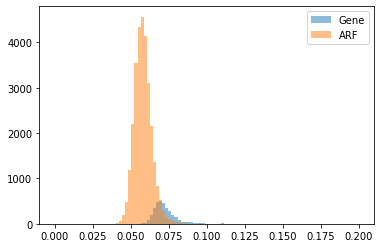

In [17]:
bins = np.linspace(0, 0.2, 100)
plt.hist(scores_GENE, bins, alpha=0.5, label="Gene")
plt.hist(scores_ARF, bins, alpha=0.5, label="ARF")
plt.legend(loc='upper right')
plt.show()

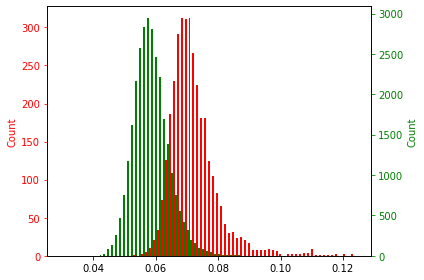

In [18]:
#https://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib
#sets up the axis and gets histogram data
colors = ["red", "green"]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([scores_GENE, scores_ARF], color=colors)
n, bins, patches = ax1.hist([scores_GENE,scores_ARF], bins=75, range=[0.03,0.125])
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * .5
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Count", color=colors[0])
ax2.set_ylabel("Count", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.tight_layout()
plt.show()

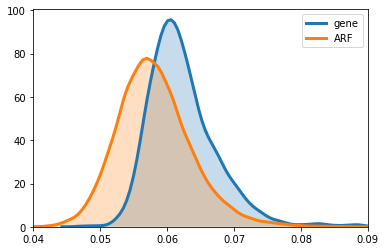

In [31]:
import seaborn as sns
sns.distplot(scores_GENE, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label = 'gene')
sns.distplot(scores_ARF, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label = 'ARF')
plt.xlim([0.04,0.09])
plt.show()